In [67]:
import datetime as dt
from pytz import timezone
from matplotlib import pyplot as plt
import pandas as pd
from IPython.display import HTML
from money_squirrel.bin import utils

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 7)

COINS = utils.load_config("coins")

def display_all(df):
    return HTML(df.to_html())

2017-06-28 05:46:30,248|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/coins.json


In [78]:
gdax_price = utils.query_pg("select * from gdax_api_quote")

2017-06-29 07:12:28,290|money_squirrel.bin.utils|INFO|Loading JSON from /Users/ravdek/code/money_squirrel/money_squirrel/config/postgres.json
2017-06-29 07:12:28,295|money_squirrel.bin.utils|INFO|Connecting to postgres DB @ localhost
2017-06-29 07:12:28,304|money_squirrel.bin.utils|INFO|Executing query:

select * from gdax_api_quote



In [79]:
gdax_price.head()

,id,product_id,granularity,dt,low,high,open,close,volume
0,357455,BTC-USD,60,2017-05-04 20:30:00-07:00,1586.22,1590.21,1590.21,1587.49,6.397862
1,357456,BTC-USD,60,2017-05-04 20:29:00-07:00,1587.28,1592.04,1587.28,1590.25,6.247373
2,357457,BTC-USD,60,2017-05-04 20:28:00-07:00,1587.24,1587.25,1587.24,1587.25,6.121972
3,357458,BTC-USD,60,2017-05-04 20:27:00-07:00,1584.09,1592.04,1592.01,1587.00,25.300739
4,357459,BTC-USD,60,2017-05-04 20:26:00-07:00,1591.07,1593.99,1593.99,1592.02,3.791762


In [80]:
gdax_price['granularity'].value_counts()

60    711548
20        43
Name: granularity, dtype: int64

In [81]:
gdax_price.loc[0, 'dt'].__class__

pandas.tslib.Timestamp

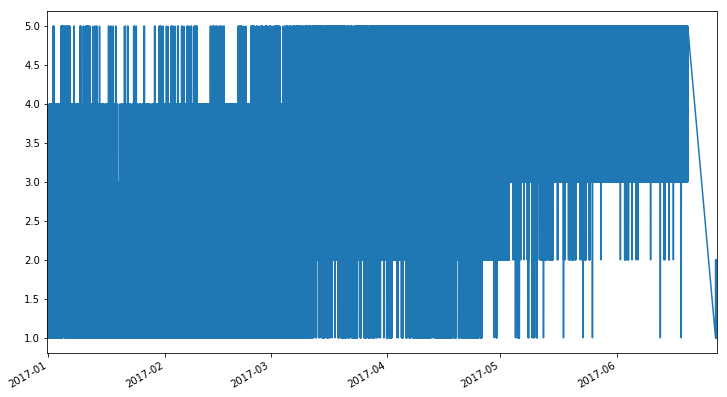

In [82]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].value_counts().plot()

In [37]:
gdax_price.loc[gdax_price['granularity']==60, 'dt'].max().replace(tzinfo=timezone('UTC'))

datetime.datetime(2017, 4, 11, 9, 39, tzinfo=<UTC>)

In [53]:
gdax_price.dt.isnull().value_counts()

False    554735
Name: dt, dtype: int64

In [54]:
gdax_price.product_id.value_counts()

BTC-USD    234963
ETH-USD    205784
LTC-USD    113988
Name: product_id, dtype: int64